In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("/home/hle12/Project/Churn/cleaned_data.csv")

In [3]:
df.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus,ServiceCity
0,3000002.0,Yes,24.00,5.393628,22.0,0.223144,0.0,0.0,-157.0,-19.0,...,4.0,No,0.000000,30.0,Yes,1-Highest,Suburban,Professional,No,SEA
1,3000010.0,Yes,16.99,2.397895,17.0,0.000000,0.0,0.0,-4.0,0.0,...,5.0,No,0.000000,30.0,No,4-Medium,Suburban,Professional,Yes,PIT
2,3000014.0,No,38.00,2.197225,38.0,0.000000,0.0,0.0,-2.0,0.0,...,6.0,No,0.000000,NaN,No,3-Good,Town,Crafts,Yes,MIL
3,3000022.0,No,82.28,7.180070,75.0,0.806476,0.0,0.0,157.0,8.1,...,6.0,No,0.000000,10.0,No,4-Medium,Other,Other,No,PIT
4,3000026.0,Yes,17.14,0.000000,17.0,0.000000,0.0,0.0,0.0,-0.2,...,9.0,No,0.693147,10.0,No,1-Highest,Other,Professional,Yes,OKC


In [4]:
df['Churn_numeric'] = df['Churn'].map({'No': 0, 'Yes': 1})

In [5]:
df['IncomeGroup'] = df['IncomeGroup'].astype('category')

# EDA for Customer Churn

First, we calculate Key Metrics include...
1. Direct Churn Rate 
2. Customer Lifetime Value (CLV)
3. Average Revenue per User (ARPU)
4. Average Months in Service
5. Median Monthly Revenue per User
6. Median Percentage Change in Revenues
7. Median Monthly Usage Minute

Churn
No     36336
Yes    14711
Name: count, dtype: int64


/tmp/ipykernel_4244/2169015147.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='husl')


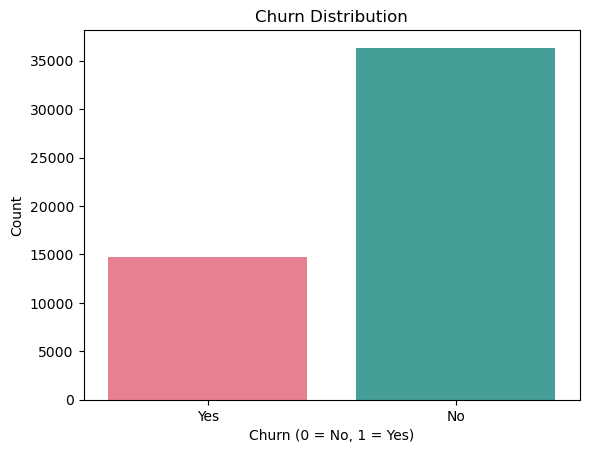

In [6]:
print(df['Churn'].value_counts())
sns.countplot(x='Churn', data=df, palette='husl')
plt.title('Churn Distribution')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

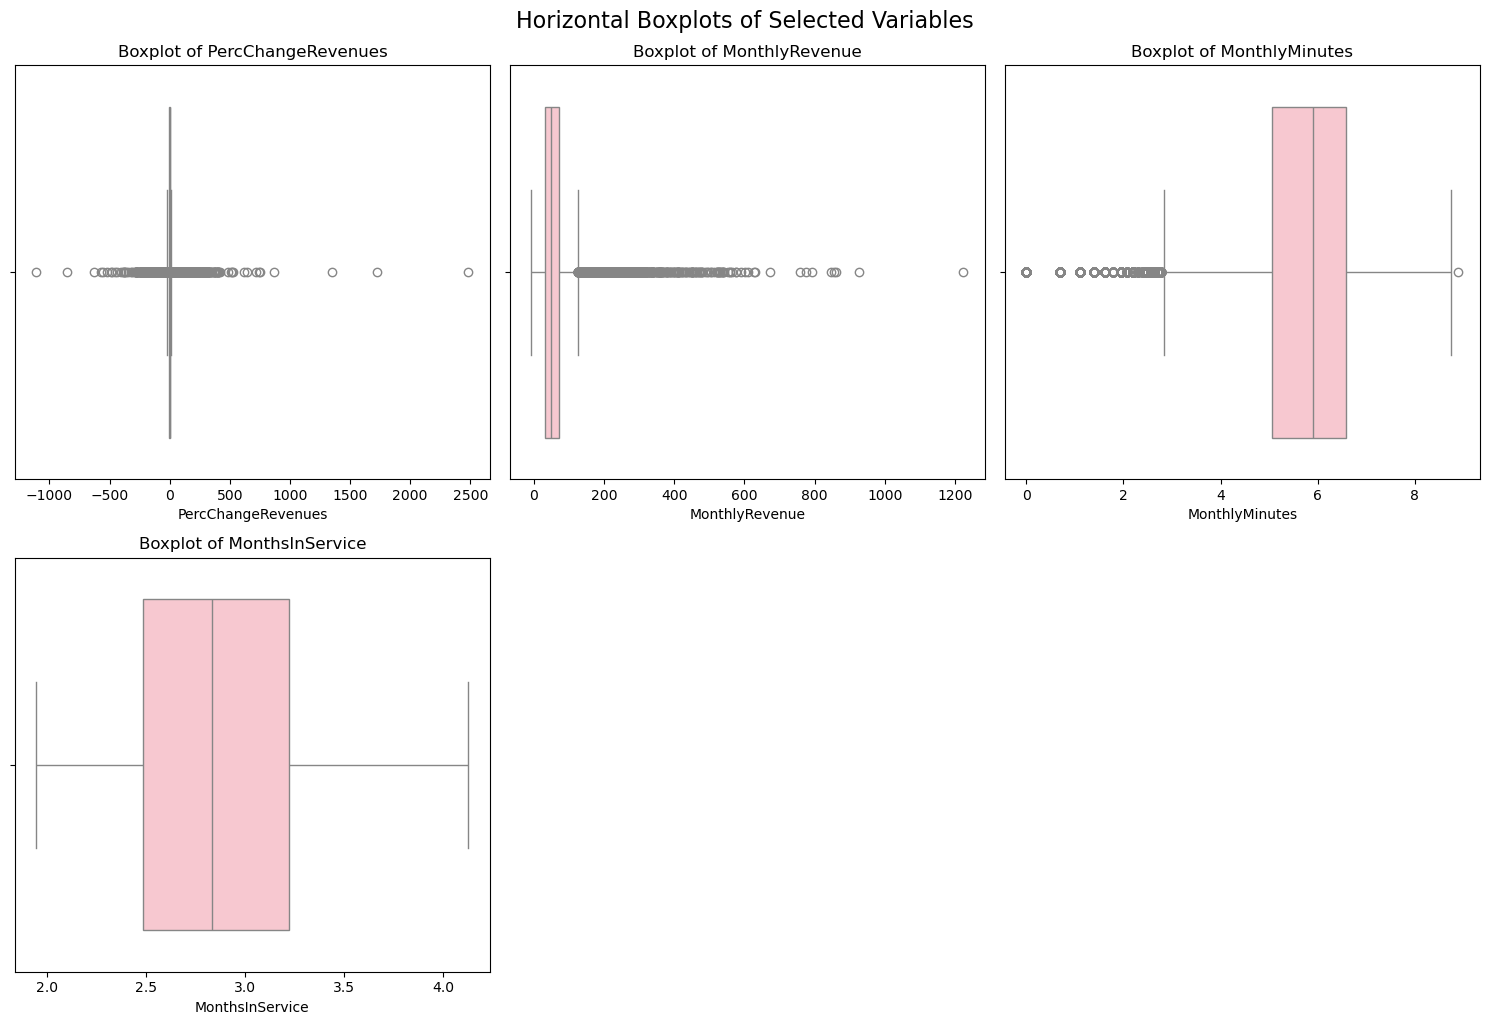

In [7]:
# Plot box plots for desired variables to figure out the ideal measure of centre

variables = ['PercChangeRevenues', 'MonthlyRevenue', 'MonthlyMinutes', 'MonthsInService']

plt.figure(figsize=(15, 10))

for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x=var, color="pink", orient='h')  # horizontal orientation
    plt.title(f'Boxplot of {var}')
    plt.tight_layout()

plt.suptitle("Horizontal Boxplots of Selected Variables", fontsize=16, y=1.02)
plt.show()


In [8]:
# Calculate churn stats
total_churned = len(df[df['Churn_numeric'] == 1])
total_customers = len(df)

Direct_Churn_Rate = (total_churned / total_customers) * 100

# Initialize Key Metrics dictionary
Key_Metrics = {
    'Direct Churn Rate': round(Direct_Churn_Rate, 2)
}

# Calculate median monthly revenue (robust to skew)
median_monthly_revenue = df['MonthlyRevenue'].median()
average_months_in_service = df['MonthsInService'].mean()

# Calculate average CLV
average_clv = median_monthly_revenue * average_months_in_service

# Round values for storage
Key_Metrics['Average Months In Service'] = float(round(average_months_in_service, 2))
Key_Metrics['Median Monthly Revenue per User'] = float(round(median_monthly_revenue, 2))
Key_Metrics['Average CLV'] = float(round(average_clv, 2))

# Calculate the median percentage change in revenue
median_percChangeRevenues = df['PercChangeRevenues'].median()

Key_Metrics['Median Percentage Change in Revenues'] = float(round(median_percChangeRevenues, 2))

# Calculate the median monthly minutes
median_MonthlyMinutes = round(df['MonthlyMinutes'].median(), 2)
Key_Metrics['Median Monthly Usage Minutes'] = float(median_MonthlyMinutes)


Key_Metrics_df = pd.DataFrame([Key_Metrics])
Key_Metrics_df

,Direct Churn Rate,Average Months In Service,Median Monthly Revenue per User,Average CLV,Median Percentage Change in Revenues,Median Monthly Usage Minutes
0,28.82,2.87,48.46,138.97,-0.3,5.91


### Key observations:

🚩 The direct churn rate of 28.82% which is alarmingly higher than the wanted churn rate of around 5-10%, indicating that the firm has a problem in customer retention. 

🚩 The average months in service is 2.87 which is considerably short for a phone plan. This is also a problem because it takes time to build customer loyalty.

🚩 Ideally, we would compare the Median Monthly Revenue per User with those of other companies.

🚩 Because customers churn quickly, total lifetime revenue is low. Ideally, telecom companies want higher CLV by increasing tenure and reducing churn.

🚩 Small negative change in revenues might indicating that customers are changing to a cheaper plan, potentially indicating that the price of an average phone plan is higher than the market.

🚩 Median monthly usage of 5.91 minutes is very low. This may signal to a problem in incorrect data entry or a service issue. 


# Feature Selection

## Run down of procedure

1. Split the entire dataframe into categories.
2. Split each categories into numerical and categorical.
3. Select variables in which the churn rate difference is larger than 5%.
4. Then, visualise these data for clarity.
5. For visualisation, use barcharts for categorical features and boxplot for continuous features.
6. Use these variables for our model.

In [9]:
customer_care_cols = [
    'CustomerCareCalls', 'RetentionCalls', 'OptOutMailings', 
    'RespondsToMailOffers', 'MadeCallToRetentionTeam', 
    'ReceivedCalls',
]

customer_credit_cols = [
    'CreditRating', 'AdjustmentsToCreditRating'
]

demo_cols = [
    'MonthsInService', 'MaritalStatus', 'AgeHH1', 'AgeHH2',
    'Handsets', 'Occupation', 'HandsetModels',
    'IncomeGroup', 'ServiceCity', 'HandsetPrice',
    'PrizmCode', 'ChildrenInHH', 'HandsetRefurbished',
    'HandsetWebCapable', 'TruckOwner', 'RVOwner', 
    'BuysViaMailOrder', 'NonUSTravel',
    'OwnsComputer', 'HasCreditCard', 'NotNewCellphoneUser',
    'OwnsMotorcycle', 'UniqueSubs', 'ActiveSubs',
    'CurrentEquipmentDays'
]

behavioural_cols = [  
    'RoamingCalls', 'OutboundCalls', 'InboundCalls', 
    'PeakCallsInOut', 'OffPeakCallsInOut', 'BlockedCalls', 
    'DroppedCalls', 'DroppedBlockedCalls', 'PercChangeMinutes',
    'ReferralsMadeBySubscriber', 'OverageMinutes', 'UnansweredCalls',
    'MonthlyMinutes', 'RetentionOffersAccepted'
]

payment_cols = [
    'MonthlyRevenue', 'TotalRecurringCharge', 'PercChangeRevenues'
]

# VAS = value-added service
VAS_cols = [
    'DirectorAssistedCalls', 'ThreewayCalls', 
    'CallForwardingCalls', 'CallWaitingCalls' 
]

customer_care = df[customer_care_cols]
demographic = df[demo_cols]
behavioural = df[behavioural_cols]
payment = df[payment_cols]
VAS = df[VAS_cols]

In [10]:
# There are too many service cities and they are not particularly helpful for analysis.
# So, drop ServiceCity

demo_cols.remove('ServiceCity')
demographic.drop('ServiceCity', axis=1, inplace=True)

print('ServiceCity' in demo_cols)
print('ServiceCity' in demographic.columns.tolist())

False
False


/tmp/ipykernel_4244/856632287.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographic.drop('ServiceCity', axis=1, inplace=True)


In [11]:
selected_features = [] 

## 1. Demographic Data

In [12]:
# Split numeric and categorical columns
numeric_demo = [col for col in demo_cols if pd.api.types.is_numeric_dtype(demographic[col])]
categorical_demo = [col for col in demo_cols if not pd.api.types.is_numeric_dtype(demographic[col])]


Churn rate by Occupation:
 Occupation
Homemaker       0.324841
Student         0.309711
Clerical        0.293103
Other           0.290459
Professional    0.281782
Crafts          0.280448
Self            0.276451
Retired         0.252387
Name: Churn_numeric, dtype: float64




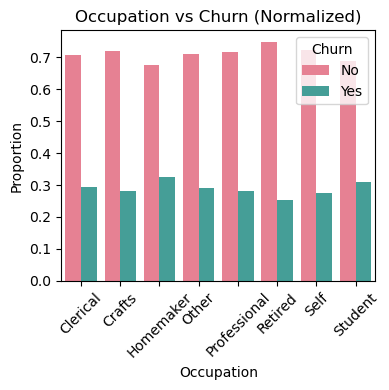


Churn rate by HandsetWebCapable:
 HandsetWebCapable
No     0.373525
Yes    0.278917
Name: Churn_numeric, dtype: float64




/tmp/ipykernel_4244/393869235.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate = df.groupby(col)['Churn_numeric'].mean().sort_values(ascending=False)


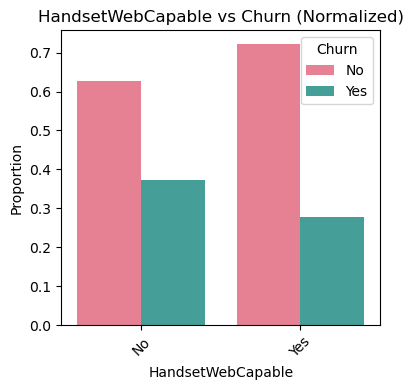

In [13]:
for col in categorical_demo:
    churn_rate = df.groupby(col)['Churn_numeric'].mean().sort_values(ascending=False)
    if (churn_rate.max() - churn_rate.min()) > 0.05:
        selected_features.append(col)
        
        print(f"\nChurn rate by {col}:\n", churn_rate)

        print(f"\n")
        
        # Calculate proportions
        prop_df = (
            df.groupby(col)['Churn']
            .value_counts(normalize=True)
            .rename('proportion')
            .reset_index()
        )

        fig, ax = plt.subplots(figsize=(4, 4)) 
    
        sns.barplot(
            x=col, y='proportion', hue='Churn', palette='husl',
            data=prop_df, ax=ax
        )
    
        ax.set_title(f"{col} vs Churn (Normalized)")
        ax.set_ylabel("Proportion")
        ax.set_xlabel(col)
        ax.tick_params(axis='x', rotation=45)
    
        plt.tight_layout()
        plt.show()



Churn rate by MonthsInService_bin:
MonthsInService_bin
(2.398, 2.708]    0.385598
(2.708, 2.996]    0.299181
(2.996, 3.296]    0.297316
(3.296, 4.127]    0.283718
(1.945, 2.398]    0.170599
Name: Churn_numeric, dtype: float64


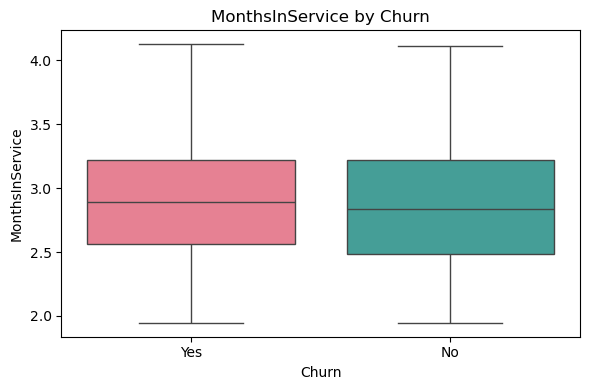


Churn rate by AgeHH1_bin:
AgeHH1_bin
(17.999, 32.0]    0.308620
(46.0, 54.0]      0.283280
(40.0, 46.0]      0.282907
(32.0, 40.0]      0.275007
(54.0, 99.0]      0.257904
Name: Churn_numeric, dtype: float64


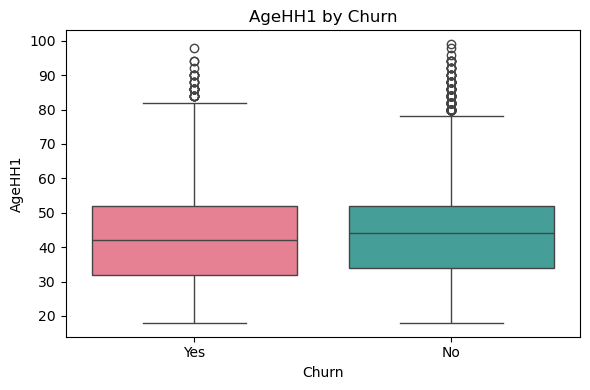


Churn rate by CurrentEquipmentDays_bin:
CurrentEquipmentDays_bin
(282.0, 383.0]     0.353490
(576.0, 1812.0]    0.342896
(383.0, 576.0]     0.324245
(-5.001, 184.0]    0.228475
(184.0, 282.0]     0.191939
Name: Churn_numeric, dtype: float64


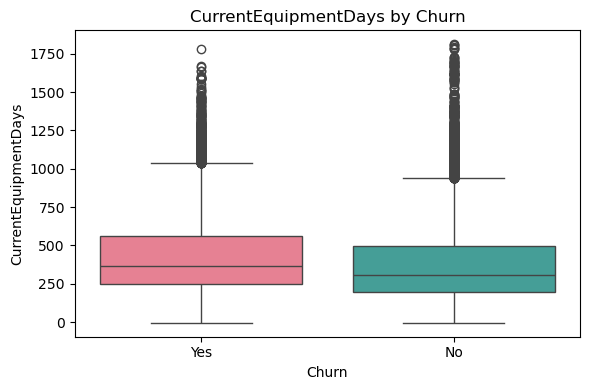

In [14]:
for col_name in numeric_demo: 
    bin_col = f"{col_name}_bin"
    
    # Create quantile-based bins
    try:
        df[bin_col] = pd.qcut(df[col_name], q=5, duplicates='drop')
    except ValueError:
        print(f"Skipping {col_name} due to insufficient unique values for binning.")
        continue

    churn_rate = df.groupby(bin_col, observed=False)['Churn_numeric'].mean().sort_values(ascending=False)

    # Compare churn rate spread 
    if (churn_rate.max() - churn_rate.min()) > 0.05:
        selected_features.append(col_name)
        
        print(f"\nChurn rate by {bin_col}:\n{churn_rate}")

        # Create boxplot of the numeric variable by Churn
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.boxplot(x='Churn', y=col_name, data=df, ax=ax, hue='Churn', palette='husl', legend=False)

        ax.set_title(f"{col_name} by Churn")
        ax.set_xlabel("Churn")
        ax.set_ylabel(col_name)

        plt.tight_layout()
        plt.show()

    df.drop(columns=[bin_col], inplace=True)


### Variables to be used from Demographic Data:

<b> Categorical data: </b> Occupation, HandsetWebCapable

<b> Continuous data: </b> MonthsInService, AgeHH1, CurrentEquipmentDays

## 2. Customer Care Data

In [15]:
# Split numeric and categorical columns
numeric_customer_care = [col for col in customer_care_cols if pd.api.types.is_numeric_dtype(customer_care[col])]
categorical_customer_care = [col for col in customer_care_cols if not pd.api.types.is_numeric_dtype(customer_care[col])]

print(len(numeric_customer_care))
print(len(categorical_customer_care))

3
3



Churn rate by MadeCallToRetentionTeam:
 MadeCallToRetentionTeam
Yes    0.450430
No     0.282443
Name: Churn_numeric, dtype: float64




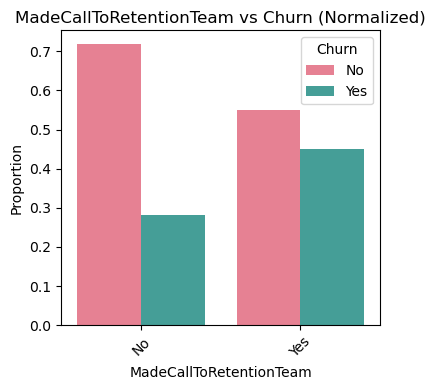

In [16]:
for col in categorical_customer_care:
    churn_rate = df.groupby(col)['Churn_numeric'].mean().sort_values(ascending=False)
    if (churn_rate.max() - churn_rate.min()) > 0.05:
        selected_features.append(col)
        
        print(f"\nChurn rate by {col}:\n", churn_rate)

        print(f"\n")
        
        # Calculate proportions
        prop_df = (
            df.groupby(col)['Churn']
            .value_counts(normalize=True)
            .rename('proportion')
            .reset_index()
        )

        fig, ax = plt.subplots(figsize=(4, 4)) 
    
        # Plot side-by-side bars (grouped, not stacked)
        sns.barplot(
            x=col, y='proportion', hue='Churn', palette='husl',
            data=prop_df, ax=ax
        )
    
        ax.set_title(f"{col} vs Churn (Normalized)")
        ax.set_ylabel("Proportion")
        ax.set_xlabel(col)
        ax.tick_params(axis='x', rotation=45)
    
        plt.tight_layout()
        plt.show()



Churn rate by CustomerCareCalls_bin:
CustomerCareCalls_bin
(-0.001, 0.262]    0.305504
(0.262, 1.194]     0.273444
(1.194, 5.794]     0.247358
Name: Churn_numeric, dtype: float64


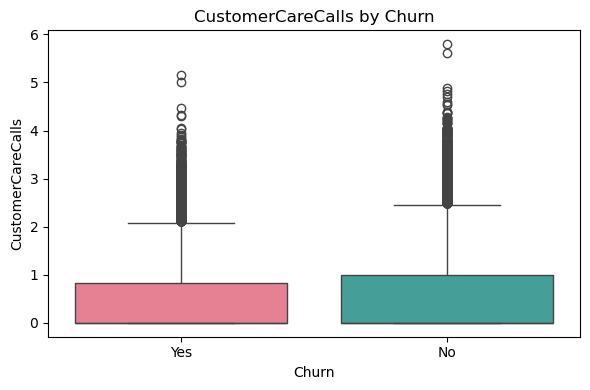


Churn rate by ReceivedCalls_bin:
ReceivedCalls_bin
(-0.001, 1.548]    0.324749
(1.548, 3.447]     0.296431
(3.447, 4.43]      0.281799
(4.43, 5.256]      0.274224
(5.256, 7.899]     0.263565
Name: Churn_numeric, dtype: float64


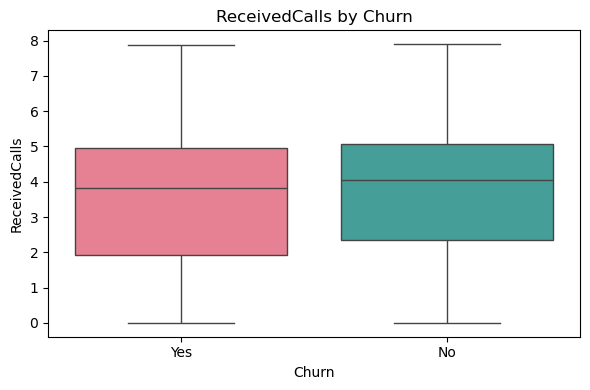

In [17]:
for col_name in numeric_customer_care: 
    bin_col = f"{col_name}_bin"
    
    # Create quantile-based bins
    try:
        df[bin_col] = pd.qcut(df[col_name], q=5, duplicates='drop')
    except ValueError:
        print(f"Skipping {col_name} due to insufficient unique values for binning.")
        continue

    churn_rate = df.groupby(bin_col, observed=False)['Churn_numeric'].mean().sort_values(ascending=False)

    # Compare churn rate spread 
    if (churn_rate.max() - churn_rate.min()) > 0.05:  
        selected_features.append(col_name)
        
        print(f"\nChurn rate by {bin_col}:\n{churn_rate}")

        # Create boxplot of the numeric variable by Churn
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.boxplot(x='Churn', y=col_name, data=df, ax=ax, hue='Churn', palette='husl')

        ax.set_title(f"{col_name} by Churn")
        ax.set_xlabel("Churn")
        ax.set_ylabel(col_name)

        plt.tight_layout()
        plt.show()

    df.drop(columns=[bin_col], inplace=True)

### Variables to be used from Customer Care Data:

<b> Categorical data: </b> MadeCallToRetentionTeam

<b> Continuous data: </b> CustomerCareCalls, ReceivedCalls

## 3. Behavioural Data

In [18]:
# Split numeric and categorical columns
numeric_behav = [col for col in behavioural_cols if pd.api.types.is_numeric_dtype(behavioural[col])]
categorical_behav = [col for col in behavioural_cols if not pd.api.types.is_numeric_dtype(behavioural[col])]

print(len(numeric_behav))
print(len(categorical_behav))

14
0



Churn rate by OutboundCalls_bin:
OutboundCalls_bin
(-0.001, 0.993]    0.328560
(0.993, 2.272]     0.289717
(2.272, 3.03]      0.281958
(3.03, 3.738]      0.274389
(3.738, 6.47]      0.265619
Name: Churn_numeric, dtype: float64


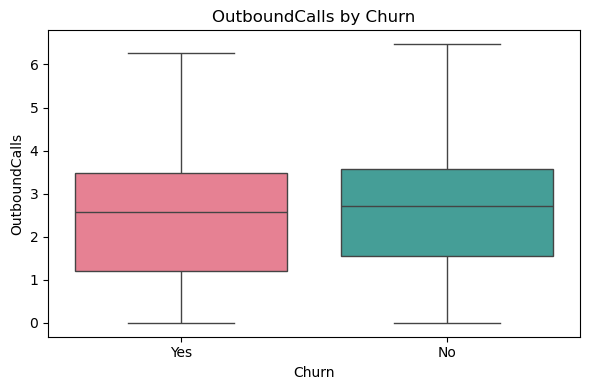


Churn rate by InboundCalls_bin:
InboundCalls_bin
(-0.001, 0.693]    0.315837
(0.693, 1.609]     0.275903
(1.609, 2.565]     0.268938
(2.565, 6.254]     0.258125
Name: Churn_numeric, dtype: float64


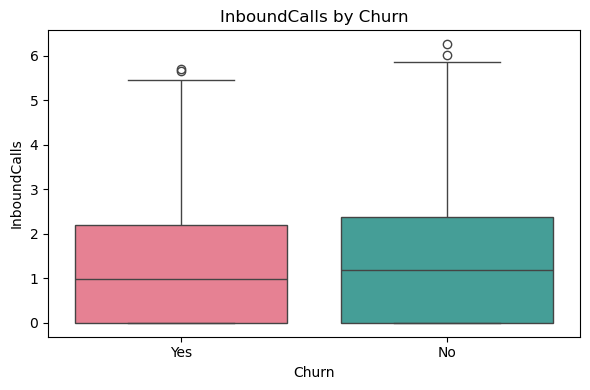


Churn rate by PeakCallsInOut_bin:
PeakCallsInOut_bin
(-0.001, 2.815]    0.330428
(2.815, 3.835]     0.288533
(3.835, 4.407]     0.282600
(4.407, 4.954]     0.279129
(4.954, 7.646]     0.260147
Name: Churn_numeric, dtype: float64


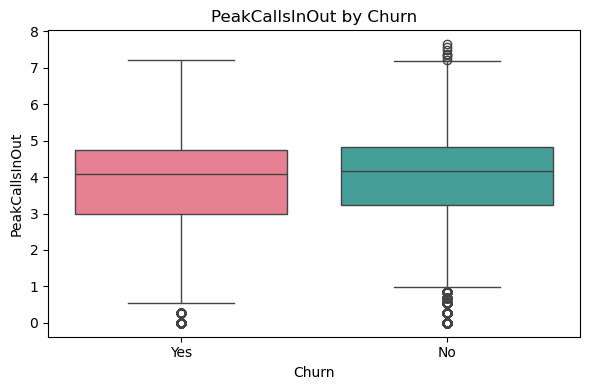


Churn rate by OffPeakCallsInOut_bin:
OffPeakCallsInOut_bin
(-0.001, 2.116]    0.333911
(2.116, 3.219]     0.289932
(3.219, 3.957]     0.287948
(3.957, 4.691]     0.268853
(4.691, 7.297]     0.259452
Name: Churn_numeric, dtype: float64


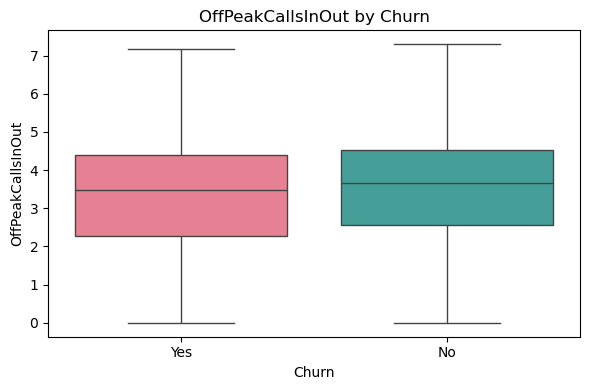


Churn rate by PercChangeMinutes_bin:
PercChangeMinutes_bin
(-3875.001, -114.0]    0.329136
(-27.0, 11.0]          0.300756
(-114.0, -27.0]        0.282912
(96.0, 5192.0]         0.262633
(11.0, 96.0]           0.254776
Name: Churn_numeric, dtype: float64


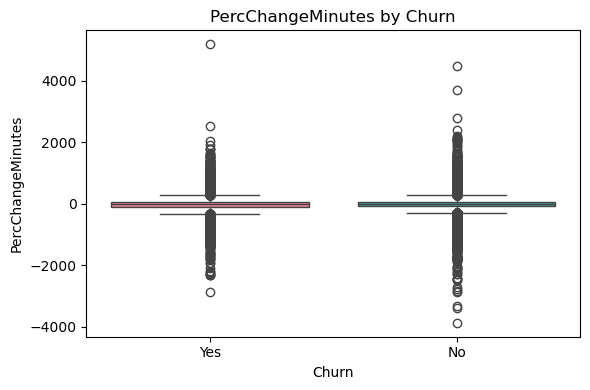


Churn rate by UnansweredCalls_bin:
UnansweredCalls_bin
(-0.001, 1.459]    0.329004
(1.459, 2.51]      0.291311
(2.51, 3.148]      0.280495
(3.148, 3.8]       0.277336
(3.8, 6.745]       0.262167
Name: Churn_numeric, dtype: float64


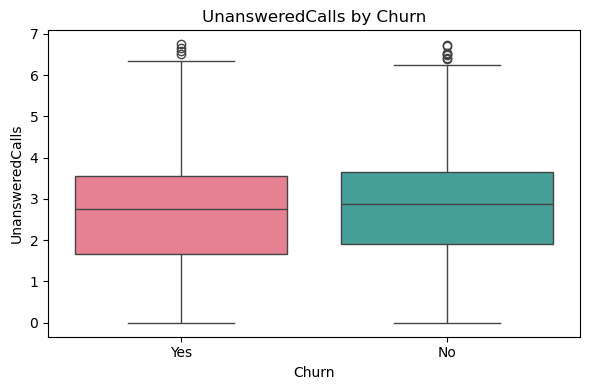


Churn rate by MonthlyMinutes_bin:
MonthlyMinutes_bin
(-0.001, 4.812]    0.340205
(4.812, 5.624]     0.291058
(5.624, 6.172]     0.278148
(6.172, 6.735]     0.270026
(6.735, 8.904]     0.258705
Name: Churn_numeric, dtype: float64


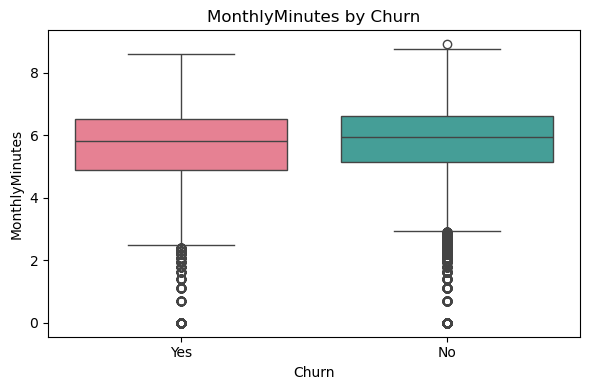

In [19]:
for col_name in numeric_behav: 
    bin_col = f"{col_name}_bin"
    
    # Create quantile-based bins
    try:
        df[bin_col] = pd.qcut(df[col_name], q=5, duplicates='drop')
    except ValueError:
        print(f"Skipping {col_name} due to insufficient unique values for binning.")
        continue

    churn_rate = df.groupby(bin_col, observed=False)['Churn_numeric'].mean().sort_values(ascending=False)

    # Compare churn rate spread 
    if (churn_rate.max() - churn_rate.min()) > 0.05: 
        selected_features.append(col_name)
        
        print(f"\nChurn rate by {bin_col}:\n{churn_rate}")

        # Create boxplot of the numeric variable by Churn
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.boxplot(x='Churn', y=col_name, data=df, ax=ax, hue = 'Churn', palette='husl')

        ax.set_title(f"{col_name} by Churn")
        ax.set_xlabel("Churn")
        ax.set_ylabel(col_name)

        plt.tight_layout()
        plt.show()

    df.drop(columns=[bin_col], inplace=True)

### Variables to be used from Customer Care Data:

<b> Categorical data: </b> 0

<b> Continuous data: </b> OutboundCalls, InboundCalls, PeakCallsInOut, OffPeakCallsInOut, PercChangeMinutes, UnansweredCalls, MonthlyMinutes

## 4. Payment Data

In [20]:
# Split numeric and categorical columns
numeric_payment = [col for col in payment_cols if pd.api.types.is_numeric_dtype(payment[col])]
categorical_payment = [col for col in payment_cols if not pd.api.types.is_numeric_dtype(payment[col])]

print(len(numeric_payment))
print(len(categorical_payment))

3
0



Churn rate by TotalRecurringCharge_bin:
TotalRecurringCharge_bin
(-11.001, 30.0]    0.335003
(30.0, 40.0]       0.298842
(49.0, 60.0]       0.285569
(40.0, 49.0]       0.254431
(60.0, 400.0]      0.240333
Name: Churn_numeric, dtype: float64


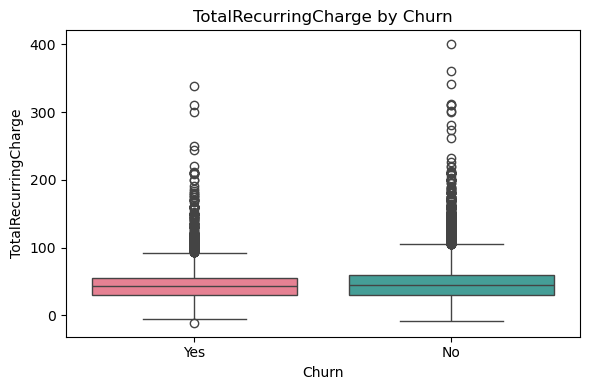

In [21]:
for col_name in numeric_payment: 
    bin_col = f"{col_name}_bin"
    
    # Create quantile-based bins
    try:
        df[bin_col] = pd.qcut(df[col_name], q=5, duplicates='drop')
    except ValueError:
        print(f"Skipping {col_name} due to insufficient unique values for binning.")
        continue

    churn_rate = df.groupby(bin_col, observed=False)['Churn_numeric'].mean().sort_values(ascending=False)

    # Compare churn rate spread 
    if (churn_rate.max() - churn_rate.min()) > 0.05:  
        selected_features.append(col_name)
        
        print(f"\nChurn rate by {bin_col}:\n{churn_rate}")

        # Create boxplot of the numeric variable by Churn
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.boxplot(x='Churn', y=col_name, data=df, ax=ax, hue='Churn', palette='husl')

        ax.set_title(f"{col_name} by Churn")
        ax.set_xlabel("Churn")
        ax.set_ylabel(col_name)

        plt.tight_layout()
        plt.show()

    df.drop(columns=[bin_col], inplace=True)

### Variables to be used from Payment Data:

<b> Categorical data: </b> 0

<b> Continuous data: </b> TotalRecurringCharge

In [22]:
# Split numeric and categorical columns
numeric_VAS = [col for col in VAS_cols if pd.api.types.is_numeric_dtype(VAS[col])]
categorical_VAS = [col for col in VAS_cols if not pd.api.types.is_numeric_dtype(VAS[col])]

print(len(numeric_VAS))
print(len(categorical_VAS))

4
0


In [23]:
for col_name in numeric_VAS: 
    bin_col = f"{col_name}_bin"
    
    # Create quantile-based bins
    try:
        df[bin_col] = pd.qcut(df[col_name], q=5, duplicates='drop')
    except ValueError:
        print(f"Skipping {col_name} due to insufficient unique values for binning.")
        continue

    churn_rate = df.groupby(bin_col, observed=False)['Churn_numeric'].mean().sort_values(ascending=False)

    # Compare churn rate spread 
    if (churn_rate.max() - churn_rate.min()) > 0.05:  
        selected_features.append(col_name)
        print(f"\nChurn rate by {bin_col}:\n{churn_rate}")

        # Create boxplot of the numeric variable by Churn
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.boxplot(x='Churn', y=col_name, data=df, ax=ax)

        ax.set_title(f"{col_name} by Churn")
        ax.set_xlabel("Churn")
        ax.set_ylabel(col_name)

        plt.tight_layout()
        plt.show()

    df.drop(columns=[bin_col], inplace=True)

### Variables to be used from VAS Data:

<b> Categorical data: </b> 0

<b> Continuous data: </b> 0

In [24]:
print(selected_features)

['Occupation', 'HandsetWebCapable', 'MonthsInService', 'AgeHH1', 'CurrentEquipmentDays', 'MadeCallToRetentionTeam', 'CustomerCareCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut', 'OffPeakCallsInOut', 'PercChangeMinutes', 'UnansweredCalls', 'MonthlyMinutes', 'TotalRecurringCharge']


In [31]:
selected_features.append('Churn')

processed_df = df[selected_features]

processed_df.head().style.set_properties()

,Occupation,HandsetWebCapable,MonthsInService,AgeHH1,CurrentEquipmentDays,MadeCallToRetentionTeam,CustomerCareCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,PercChangeMinutes,UnansweredCalls,MonthlyMinutes,TotalRecurringCharge,Churn
0,Professional,Yes,4.127134,62.000000,361.000000,Yes,0.000000,4.587006,0.000000,0.000000,4.077537,3.218876,-157.000000,1.987874,5.393628,22.000000,Yes
1,Professional,No,4.077537,40.000000,1504.000000,No,0.000000,0.000000,0.000000,0.000000,1.791759,0.693147,-4.000000,1.308333,2.397895,17.000000,Yes
2,Crafts,No,4.110874,26.000000,1812.000000,No,0.000000,0.336472,0.262364,0.000000,0.832909,1.547563,-2.000000,0.000000,2.197225,38.000000,No
3,Other,Yes,4.094345,30.000000,458.000000,No,1.667707,5.304796,5.917010,4.997212,6.322026,5.719328,157.000000,4.343805,7.180070,75.000000,No
4,Professional,No,3.988984,46.000000,852.000000,No,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,Yes


### Null Imputations

In [32]:
# Create a DataFrame with columns having missing values
null_df = processed_df.isnull().sum()[processed_df.isnull().sum() > 0].to_frame(name='null_count').reset_index()

# Total rows count
total_len = len(processed_df)

# Add missing value proportion (%)
null_df['null_proportion(%)'] = null_df['null_count'] / total_len * 100
print(f"{null_df} \n")

# Rename columns for clarity
null_df.columns = ['column', 'null_count', 'null_proportion(%)']

# List of columns with missing values
null_cols = null_df['column'].tolist()

non_numerical = []
skewness_list = []

# Calculate skewness for numeric columns; track non-numeric columns
for col_name in null_cols:
    if pd.api.types.is_numeric_dtype(processed_df[col_name]):
        skewness_list.append(df[col_name].skew())
    else:
        non_numerical.append(col_name)

# Create a copy of null_df for numeric columns only (drop non-numerical)
numerical_null_df = null_df[~null_df['column'].isin(non_numerical)].copy()

# Add skewness values to the filtered DataFrame
numerical_null_df['Skewness'] = skewness_list

print(numerical_null_df)

                  index  null_count  null_proportion(%)
0                AgeHH1       14826           29.043822
1  CurrentEquipmentDays           1            0.001959
2     PercChangeMinutes         367            0.718945
3        MonthlyMinutes         156            0.305601
4  TotalRecurringCharge         156            0.305601 

                 column  null_count  null_proportion(%)  Skewness
0                AgeHH1       14826           29.043822  0.462824
1  CurrentEquipmentDays           1            0.001959  1.086106
2     PercChangeMinutes         367            0.718945 -0.324255
3        MonthlyMinutes         156            0.305601 -1.502617
4  TotalRecurringCharge         156            0.305601  1.629344


In [33]:
# Now that EDA have been done, we can impute null values. 

# null_df shows that there are data with a high skewness value, so median imputations for NaN values would be prefered. 
# avoid imputing for columns where null proportion is high to reduce risk of distorting data

# Make a deep copy to avoid SettingWithCopyWarning
processed_df = df[selected_features].copy()

# Identify columns to be imputed (null proportion < 30%)
to_be_imputed = null_df.loc[null_df['null_proportion(%)'] < 30, 'column'].tolist()
print(to_be_imputed)

# Impute values
for col_name in to_be_imputed:
    if pd.api.types.is_numeric_dtype(processed_df[col_name]):
        median_val = processed_df[col_name].median(skipna=True)
        processed_df.loc[:, col_name] = processed_df[col_name].fillna(median_val)
    else:
        mode_val = processed_df[col_name].mode()
        if not mode_val.empty:
            processed_df.loc[:, col_name] = processed_df[col_name].fillna(mode_val[0])

# Validate imputation
null_df_2 = processed_df.isnull().sum()[processed_df.isnull().sum() > 0].to_frame(name='null_count').reset_index()
print(f"\n Null values were NOT imputed: {not null_df_2.empty}")


['AgeHH1', 'CurrentEquipmentDays', 'PercChangeMinutes', 'MonthlyMinutes', 'TotalRecurringCharge']

 Null values were NOT imputed: False


In [34]:
print(selected_features)

['Occupation', 'HandsetWebCapable', 'MonthsInService', 'AgeHH1', 'CurrentEquipmentDays', 'MadeCallToRetentionTeam', 'CustomerCareCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut', 'OffPeakCallsInOut', 'PercChangeMinutes', 'UnansweredCalls', 'MonthlyMinutes', 'TotalRecurringCharge', 'Churn']


In [35]:
processed_df.to_csv('post_EDA.csv', index=False)